In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import multiprocessing as mp
from joblib import Parallel, delayed

from nosh.sim import NoshGraphSimulation
import nosh.utils as uu

In [103]:
output_dir=os.path.join(os.environ['HOME'], 'Documents', 'nosh', 'outputs')
os.makedirs(output_dir, exist_ok=True)

In [104]:
# from: https://github.com/oliviaguest/gini
# modified to ignore nans, b/c our matrix is built with nans indicating something else than
# what is intended by the gini calculation
def gini(array):
    # drop nans from array
    array = array[~np.isnan(array)]
    
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted

    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient


In [105]:
class AlphaModulator:
    def __init__(self, alpha=3, alpha_max=5, alpha_min=1, ma_history_len=10):
        self.alpha = alpha
        self.alpha_max = alpha_max
        self.alpha_min = alpha_min
        self.alpha_history = []
        self.network_state_history = []
        self.ma_history_len = ma_history_len

    def modulate_alpha(self, graph_metric_prev_step):
        if graph_metric_prev_step is None:
            alpha_val = self.alpha
            network_state = None
        else:
            network_state = graph_metric_prev_step['network_state']
            if len(self.network_state_history) >= self.ma_history_len:
                if network_state < np.mean(self.network_state_history[-self.ma_history_len:]):
                    # this condition indicates we are getting closer to a powerlaw distribution
                    # for the network, meaning more scale-free and less random, 
                    # considered in our case, more mature
                    alpha_val = self.alpha + 0.1
                else:
                    # this condition indicates we are getting further from a powerlaw distribution
                    # for the network, meaning more random and less scale-free,
                    # considered in our case, less mature
                    alpha_val = self.alpha - 0.1
            else:
                alpha_val = self.alpha
        
        # keep within range
        self.alpha = np.clip(alpha_val, self.alpha_min, self.alpha_max)

        # update history
        self.alpha_history.append(self.alpha)
        if network_state is not None:
            self.network_state_history.append(network_state)

        return self.alpha


In [106]:
## function to run the simulation for the parameters we care about
def run_network_growth_simulation(ec_alpha_vec_or_fn, add_delete_maintain_trajectory, 
                                  seed_start=1, num_time_steps=100,
                                  verbose=False):
    ###  In this, we don't alter reputation scores for simplicity, we can change this assumption later
    initial_buyers_kwargs = [
        {
            'transact_probability': 0.3,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
        {
            'transact_probability': 0.3,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
        {
            'transact_probability': 0.3,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
    ]
    initial_sellers_kwargs = [
        {
            'transact_probability': 1.0, 
            'unstake_probability': 0.0,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
        {
            'transact_probability': 1.0, 
            'unstake_probability': 0.0,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
        {
            'transact_probability': 1.0, 
            'unstake_probability': 0.0,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
    ]
    new_buyer_kwargs = {
        'transact_probability': 0.3,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }
    new_seller_kwargs = {
        'transact_probability': 1.0, 
        'unstake_probability': 0.0,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }
    
    simulation = NoshGraphSimulation(
        initial_buyers_kwargs, 
        initial_sellers_kwargs,
        new_buyer_kwargs,
        new_seller_kwargs,
        seed=seed_start
    )

    # Run the simulation
    weight_alpha_vec = np.ones(num_time_steps) * 1
    reputation_alpha_vec = np.ones(num_time_steps) * 1
    graph_evolution_metrics = simulation.run(
        num_time_steps, 
        add_delete_maintain_trajectory, 
        weight_alpha_vec,
        ec_alpha_vec_or_fn,
        reputation_alpha_vec,
        verbose=verbose
    )

    num_sellers_vec = np.zeros(num_time_steps)
    num_buyers_vec = np.zeros(num_time_steps)
    network_state_vec = np.zeros(num_time_steps)
    ec_alpha_vec_actual = np.zeros(num_time_steps)
    total_graph_value_vec = np.zeros(num_time_steps)
    for t in range(num_time_steps):
        num_sellers_vec[t] = graph_evolution_metrics[t]['num_total_sellers']
        num_buyers_vec[t] = graph_evolution_metrics[t]['num_total_buyers']
        network_state_vec[t] = graph_evolution_metrics[t]['network_state']
        if isinstance(ec_alpha_vec_or_fn, str) and ec_alpha_vec_or_fn == 'dynamic':
            ec_alpha_vec_actual[t] = graph_evolution_metrics[t]['alpha']
        else:
            ec_alpha_vec_actual[t] = graph_evolution_metrics[t]['ec_alpha']
        total_graph_value_vec[t] = graph_evolution_metrics[t]['total_graph_value']

    info_dict = {
        'ec_alpha_vec': ec_alpha_vec_actual,
        # 'graph_evolution_metrics': graph_evolution_metrics,
        'seller2ec_by_t': uu.eigenvector_centrality_metric_fn(graph_evolution_metrics),
        'seller2totalweight_by_t': uu.total_weight_metric_fn(graph_evolution_metrics),
        'seller2graphvalue_by_t': uu.seller_totalvalue_metric_fn(graph_evolution_metrics),
        'network_state_by_t': network_state_vec,
        'num_sellers_vec': num_sellers_vec,
        'num_buyers_vec': num_buyers_vec,
        'total_graph_value_vec': total_graph_value_vec,
    }

    return info_dict

def run_network_growth_simulation_parallel(ec_alpha_vec_or_fn, add_delete_maintain_trajectory, 
                                           seed_start=1, num_time_steps=100, num_mc=1,
                                           verbose=False, nj=-1):
    # Define a function for running the simulation
    def run_simulation(mc_index):
        return run_network_growth_simulation(
            ec_alpha_vec_or_fn, add_delete_maintain_trajectory, 
            seed_start=seed_start + mc_index, num_time_steps=num_time_steps,
            verbose=verbose
        )

    # Execute simulations in parallel
    all_results = Parallel(n_jobs=nj)(delayed(run_simulation)(i) for i in range(num_mc))
    # all_results = []
    # for i in range(num_mc):
    #     all_results.append(run_simulation(i))

    return all_results

In [107]:
def exponential_increase_trajectory(a, b, x):
    t = np.linspace(0, 1, x)
    trajectory = a * (b / a) ** t
    return trajectory

def exponential_decrease_trajectory(a, b, x):
    t = np.linspace(0, 1, x)
    trajectory = a * (b / a) ** (1-t)
    return trajectory

def compute_growth_rate(vector, window_size=7):
    rolling_diff = pd.Series(vector).diff().rolling(window=window_size).mean().dropna()
    # scale by total number of nodes
    return rolling_diff / vector[window_size:] * 100

In [108]:
num_time_steps = 300
min_alpha = 1
max_alpha = 5
trajectory1 = np.ones((num_time_steps, 3)) * [0.2, 0.0, 0.8]
# trajectory2 = np.ones((num_time_steps, 3)) * [0.5, 0.0, 0.5]
trajectory3 = np.ones((num_time_steps, 3)) * [0.8, 0.0, 0.2]

# make a cyclic trajectory
cyclic_trajectory = np.ones((num_time_steps, 3))
cyclic_trajectory[0:100, :] *= [0.8, 0.0, 0.2]
cyclic_trajectory[100:150, :] *= [0.0, 0.5, 0.5]
cyclic_trajectory[150:200, :] *= [0.5, 0.0, 0.5]
cyclic_trajectory[200:250, :] *= [0.0, 0.5, 0.5]
cyclic_trajectory[250:300, :] *= [0.5, 0.0, 0.5]

num_mc=10
key2growthtrajectory = {
    'Pr[+]=0.2': trajectory1,
    # 'Pr[+]=0.5': trajectory2,
    'Pr[+]=0.8': trajectory3,
    'Cyclic': cyclic_trajectory,
}

In [109]:
nj=1
growthtrajectory2results = {}
for key, gt in tqdm(key2growthtrajectory.items()):
    const1_ec_alpha_growth_results = run_network_growth_simulation_parallel(
        ec_alpha_vec_or_fn=np.ones(num_time_steps) * 1, 
        add_delete_maintain_trajectory=gt,
        seed_start=1,
        num_time_steps=num_time_steps,
        num_mc=num_mc,
        verbose=False,
        nj=nj
    )
    const5_ec_alpha_growth_results = run_network_growth_simulation_parallel(
        ec_alpha_vec_or_fn=np.ones(num_time_steps) * 5, 
        add_delete_maintain_trajectory=gt,
        seed_start=1,
        num_time_steps=num_time_steps,
        num_mc=num_mc,
        verbose=False,
        nj=nj
    )
    dyanmic_alpha_growth_results = run_network_growth_simulation_parallel(
        ec_alpha_vec_or_fn='dynamic', 
        add_delete_maintain_trajectory=gt,
        seed_start=1,
        num_time_steps=num_time_steps,
        num_mc=num_mc,
        verbose=False,
        nj=nj
    )
    # rampup_ec_alpha_growth_results = run_network_growth_simulation_parallel(
    #     ec_alpha_vec_or_fn=np.linspace(min_alpha, max_alpha, num_time_steps), 
    #     add_delete_maintain_trajectory=gt,
    #     seed_start=1,
    #     num_time_steps=num_time_steps,
    #     num_mc=num_mc,
    #     verbose=False,
    #     nj=nj
    # )
    # rampdown_ec_alpha_growth_results = run_network_growth_simulation_parallel(
    #     ec_alpha_vec_or_fn=np.linspace(max_alpha, min_alpha, num_time_steps), 
    #     add_delete_maintain_trajectory=gt,
    #     seed_start=1,
    #     num_time_steps=num_time_steps,
    #     num_mc=num_mc,
    #     verbose=False,
    #     nj=nj
    # )

    # alpha_fn = AlphaModulator(alpha=3, alpha_max=5, alpha_min=1)
    # adaptive_alpha_results = run_network_growth_simulation_parallel(
    #     ec_alpha_vec_or_fn=alpha_fn.modulate_alpha, 
    #     add_delete_maintain_trajectory=gt,
    #     seed_start=1,
    #     num_time_steps=num_time_steps,
    #     num_mc=num_mc,
    #     verbose=False,
    #     nj=nj
    # )

    growthtrajectory2results[key] = {
        'const1': const1_ec_alpha_growth_results,
        'const5': const5_ec_alpha_growth_results,
        'dynamic': dyanmic_alpha_growth_results,
        # 'rampup': rampup_ec_alpha_growth_results,
        # 'rampdown': rampdown_ec_alpha_growth_results,
        # 'adaptive': adaptive_alpha_results,
    }

  0%|          | 0/3 [00:00<?, ?it/s]

/home/kiran/code/cel/nosh/nosh/sim.py:60: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis_value = scipy.stats.kurtosis(degrees)


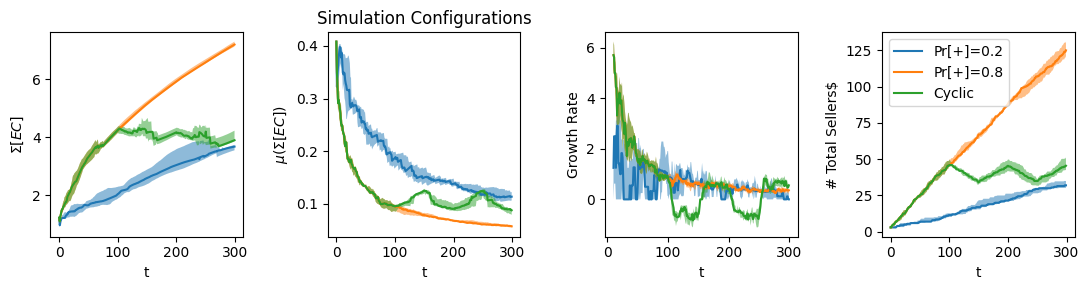

In [110]:
# plot simulation setup
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(11, 3))


ecsum_min, ecsum_max = np.inf, -np.inf
gr_min, gr_max = np.inf, -np.inf
num_sellers_min, num_sellers_max = np.inf, -np.inf
growth_rate_window_size=10
for growth_trajectory, simresults in growthtrajectory2results.items():
    ec_trajectory = 'const1' # this is a noop with the way the simulation is currently setup
    results = simresults[ec_trajectory]
    # get the graph value for each seller
    ecsum_mcmc_matrix = np.zeros((num_mc, num_time_steps))
    ecavg_mcmc_matrix = np.zeros((num_mc, num_time_steps))
    growth_rate_mcmc_matrix = np.zeros((num_mc, num_time_steps-growth_rate_window_size))
    num_sellers_mcmc_matrix = np.zeros((num_mc, num_time_steps))
    for ii in range(num_mc):
        ec_matrix = results[ii]['seller2ec_by_t']
        
        ec_sum = np.nansum(ec_matrix, axis=0)
        ecsum_min = min(ecsum_min, np.nanmin(ec_sum))
        ecsum_max = max(ecsum_max, np.nanmax(ec_sum))
        
        # compute network growth rate
        num_sellers_vec = results[ii]['num_sellers_vec']
        num_buyers_vec = results[ii]['num_buyers_vec']
        growth_rate = compute_growth_rate(num_sellers_vec, window_size=growth_rate_window_size)
        gr_min = min(gr_min, np.nanmin(growth_rate))
        gr_max = max(gr_max, np.nanmax(growth_rate))
        num_sellers_min = min(num_sellers_min, np.nanmin(num_sellers_vec))
        num_sellers_max = max(num_sellers_max, np.nanmax(num_sellers_vec))

        ecsum_mcmc_matrix[ii, :] = ec_sum
        ecavg_mcmc_matrix[ii, :] = ec_sum / num_sellers_vec
        growth_rate_mcmc_matrix[ii, :] = growth_rate
        num_sellers_mcmc_matrix[ii, :] = num_sellers_vec

    qq = np.quantile(ecsum_mcmc_matrix, [0.25, 0.5, 0.75], axis=0)
    ax[0].plot(range(num_time_steps), qq[1], label=growth_trajectory)
    ax[0].fill_between(range(num_time_steps), qq[0], qq[2], alpha=0.5)
    ax[0].set_ylabel(r'$\Sigma[EC]$')
    ax[0].set_xlabel('t')

    qq = np.quantile(ecavg_mcmc_matrix, [0.25, 0.5, 0.75], axis=0)
    ax[1].plot(range(num_time_steps), qq[1], label=growth_trajectory)
    ax[1].fill_between(range(num_time_steps), qq[0], qq[2], alpha=0.5)
    ax[1].set_ylabel(r'$\mu(\Sigma[EC])$')
    ax[1].set_xlabel('t')

    qq = np.quantile(growth_rate_mcmc_matrix, [0.25, 0.5, 0.75], axis=0)
    ax[2].plot(range(growth_rate_window_size, num_time_steps), qq[1], label=growth_trajectory)
    ax[2].fill_between(range(growth_rate_window_size, num_time_steps), qq[0], qq[2], alpha=0.5)
    ax[2].set_ylabel(r'Growth Rate')
    ax[2].set_xlabel('t')

    qq = np.quantile(num_sellers_mcmc_matrix, [0.25, 0.5, 0.75], axis=0)
    ax[3].plot(range(0, num_time_steps), qq[1], label=growth_trajectory)
    ax[3].fill_between(range(0, num_time_steps), qq[0], qq[2], alpha=0.5)
    ax[3].set_ylabel(r'# Total Sellers$')
    ax[3].set_xlabel('t')
    ax[3].legend()

ax[1].set_title('Simulation Configurations')
plt.tight_layout()

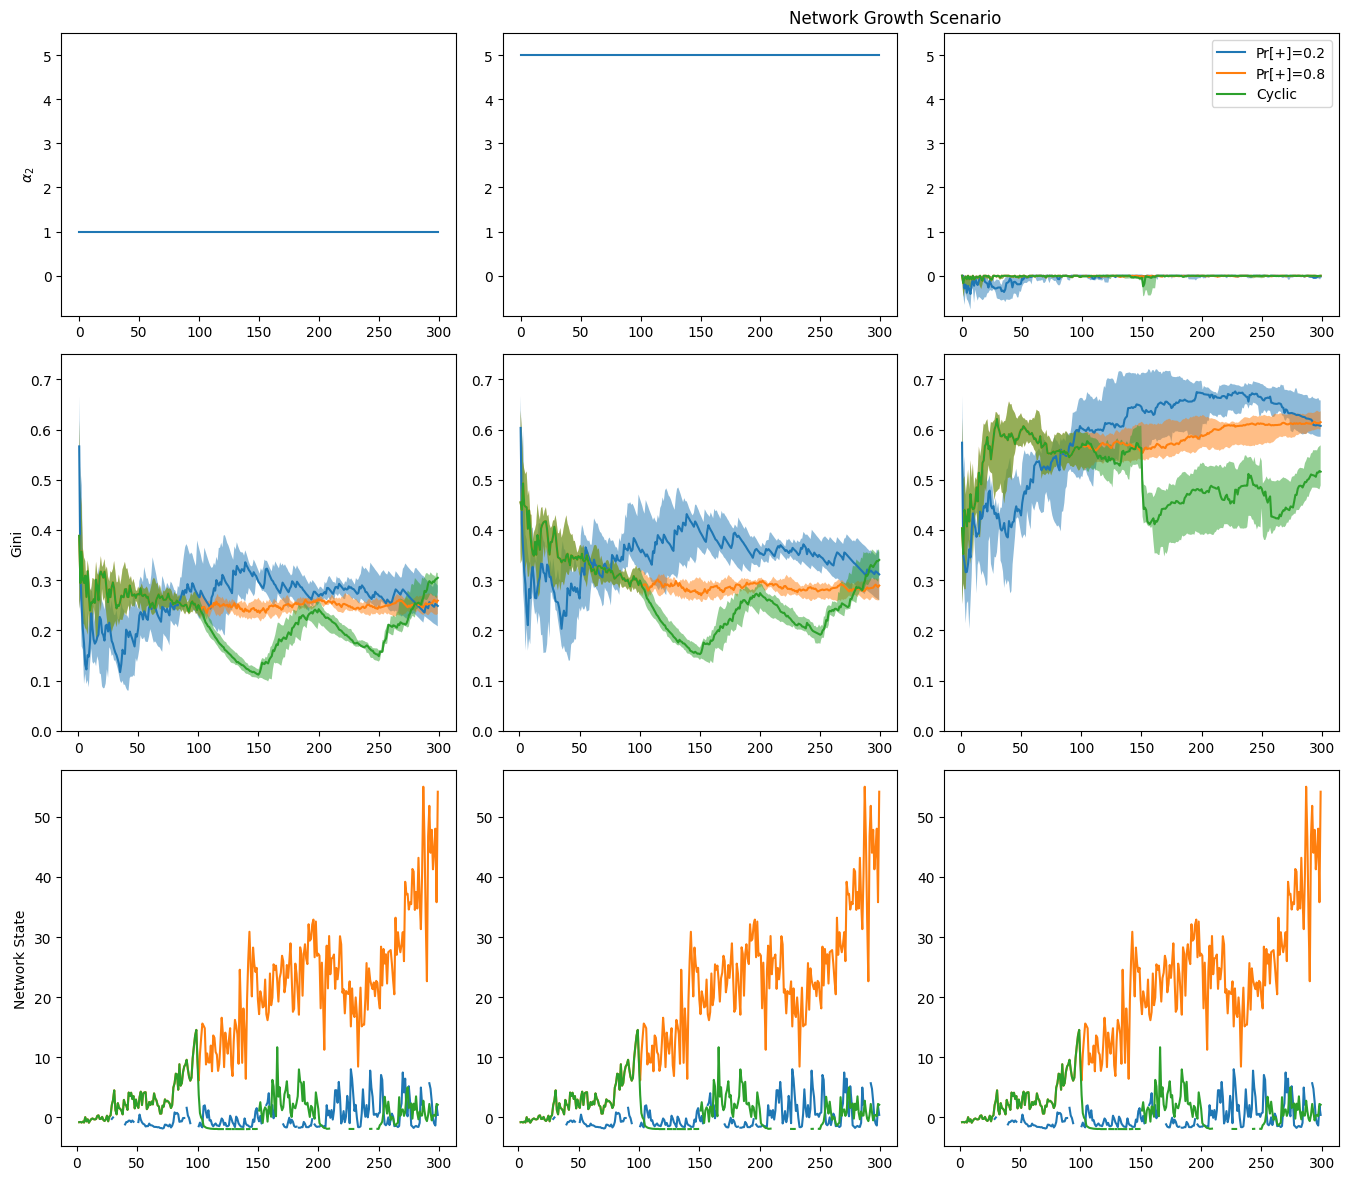

In [111]:
fig = plt.figure(figsize=(18, 12))
nrows = 3
ncols = 4
height_ratios = [3, 4, 4]
width_ratios = [1] * ncols
gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, height_ratios=height_ratios, width_ratios=width_ratios)

ec2col = {
    'const1': 0,
    'const5': 1,
    # 'rampup': 2,
    # 'rampdown': 3,
    'dynamic': 2,
}

# plot top row, it is an input
# TODO: need to plot the alpha trajectory for the 
sharey_vec = []
min_ec_alpha = np.inf
max_ec_alpha = -np.inf
for ec_trajectory, col_ix in ec2col.items():
    axx = fig.add_subplot(gs[0, col_ix])
    if col_ix == 0: axx.set_ylabel(r'$\alpha_2$')
    sharey_vec.append(axx)
    if 'const' in ec_trajectory:
        ec_alpha = growthtrajectory2results['Pr[+]=0.2'][ec_trajectory][0]['ec_alpha_vec']
        axx.plot(ec_alpha)
        min_ec_alpha = min(min_ec_alpha, np.nanmin(ec_alpha))
        max_ec_alpha = max(max_ec_alpha, np.nanmax(ec_alpha))
    else:
        # we need to plot all of them
        for gt in list(key2growthtrajectory.keys()):
            ec_alpha_matrix = np.zeros((num_mc, num_time_steps))
            for ii in range(num_mc):
                ec_alpha = growthtrajectory2results[gt][ec_trajectory][ii]['ec_alpha_vec']
                ec_alpha_matrix[ii, :] = ec_alpha
                min_ec_alpha = min(min_ec_alpha, np.nanmin(ec_alpha))
                max_ec_alpha = max(max_ec_alpha, np.nanmax(ec_alpha))
            qq = np.quantile(ec_alpha_matrix, [0.25, 0.5, 0.75], axis=0)
            axx.plot(qq[1], label=gt)
            axx.fill_between(range(num_time_steps), qq[0], qq[2], alpha=0.5)
# share y-axis with the axes objects in sharey_vec
plt.legend()
for ax in sharey_vec:
    ax.set_ylim([min_ec_alpha*0.9, max_ec_alpha*1.1])

key2axx = {}
# create the axes for the gini and growth rate plots
for ec_trajectory, plot_col in ec2col.items():
    axx_gini = fig.add_subplot(gs[1, plot_col])
    axx_kl = fig.add_subplot(gs[2, plot_col])
    # axx_tgv = fig.add_subplot(gs[3, plot_col])
    # key2axx[ec_trajectory] = (axx_gini, axx_kl, axx_tgv)
    key2axx[ec_trajectory] = (axx_gini, axx_kl)

# plot gini and growth rate for each scenario and growth trajectory
gini_min, gini_max = np.inf, -np.inf
for growth_trajectory, simresults in growthtrajectory2results.items():
    for ec_trajectory, plot_col in ec2col.items():
        results = simresults[ec_trajectory]
        # get the graph value for each seller
        gini_mcmc_matrix = np.zeros((num_mc, num_time_steps-1))
        dist_mcmc_matrix = np.zeros((num_mc, num_time_steps-1))
        total_graphvalue_matrix = np.zeros((num_mc, num_time_steps-1))
        for ii in range(num_mc):
            graph_value_matrix = results[ii]['seller2graphvalue_by_t'][:,1:]
            dist_vector = results[ii]['network_state_by_t'][1:]
            total_graph_value_vector = np.nansum(graph_value_matrix, axis=0)
            
            # compute gini coefficient on each column of graph_value_matrix
            gini_coefficients = np.apply_along_axis(gini, 0, graph_value_matrix)
            gini_min = min(gini_min, np.nanmin(gini_coefficients))
            gini_max = max(gini_max, np.nanmax(gini_coefficients))

            gini_mcmc_matrix[ii, :] = gini_coefficients
            dist_mcmc_matrix[ii, :] = dist_vector
            total_graphvalue_matrix[ii, :] = total_graph_value_vector
            
        # axx_gini, axx_kl, axx_tgv  = key2axx[ec_trajectory]
        axx_gini, axx_kl  = key2axx[ec_trajectory]

        qq = np.quantile(gini_mcmc_matrix, [0.25, 0.5, 0.75], axis=0)
        axx_gini.plot(range(1, num_time_steps), qq[1], label=growth_trajectory)
        axx_gini.fill_between(range(1, num_time_steps), qq[0], qq[2], alpha=0.5)
        if plot_col == 0: 
            axx_gini.set_ylabel('Gini')

        qq = np.quantile(dist_mcmc_matrix, [0.25, 0.5, 0.75], axis=0)
        axx_kl.plot(range(1, num_time_steps), qq[1], label=growth_trajectory)
        # axx_kl.fill_between(range(1, num_time_steps), qq[0], qq[2], alpha=0.5)
        if plot_col == 0: 
            axx_kl.set_ylabel('Network State')

        # qq = np.quantile(total_graphvalue_matrix, [0.25, 0.5, 0.75], axis=0)
        # axx_tgv.plot(range(1, num_time_steps), qq[1], label=growth_trajectory)
        # # axx_kl.fill_between(range(1, num_time_steps), qq[0], qq[2], alpha=0.5)
        # if plot_col == 0: 
        #     axx_tgv.set_ylabel('Total Graph Value')

for key, axxes in key2axx.items():
    axx = axxes[0]
    axx.set_ylim([gini_min, gini_max])

plt.suptitle('Network Growth Scenario')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'ec_alpha_growth.png'))